In [1]:
import pandas as pd 
import numpy as np
import math
import collections
from sklearn.model_selection import train_test_split
from collections import defaultdict
# import seaborn as sns
import matplotlib.pyplot as plt

## 2. Check whether the email containing the sentence ”Good, nice, little stars.” is spam or ham using multinomial Naive Bayes text classification. The training data are as
## follows:

#### “Good to see you. Good day. ” spam
#### “See the sky. See the little stars.” ham
#### “Nice picture. Nice, nice, frame. ” ham
#### “See you. Good day. ” spam

In [2]:
training_dataset = [
    ("Good to see you. Good day.", "spam"),
    ("See the sky. See the little stars.", "ham"),
    ("Nice picture. Nice, nice, frame.", "ham"),
    ("See you. Good day.", "spam"),
]
# training_dataset

test_data = "Good, nice, little stars."

In [3]:
total_messages = len(training_dataset)
spam_count = sum(1 for _, label in training_dataset if label == "spam")
ham_count = total_messages - spam_count
p_spam = spam_count / total_messages
p_ham = ham_count / total_messages

# print(p_ham, p_spam)
spam_word_counts = {}
ham_word_counts = {}

#calculating word counts for spam and ham
for content, label in training_dataset:
    words = content.split(" ")
    for word in words:
        if label == "spam":
            if word not in spam_word_counts:
                spam_word_counts[word] = 0
            spam_word_counts[word] += 1
        else:
            if word not in ham_word_counts:
                ham_word_counts[word] = 0
            ham_word_counts[word] += 1

# print(spam_word_counts)
# print(ham_word_counts)

#calculating the conditional probabilities of each word
def calculate_conditional_probabilities(word, label):
    if label == "spam":
        return (spam_word_counts.get(word, 0)+ 1) / (sum(spam_word_counts.values()) + len(spam_word_counts))
    else:
        return (ham_word_counts.get(word, 0) + 1) / (sum(ham_word_counts.values()) + len(ham_word_counts))
    
#calculating the probability of an sentance being spam or ham
def calculate_spam_ham_probabilities(content):
    words = content.split(" ")
    p_spam_given_message = math.log(p_spam)
    p_ham_given_message = math.log(p_ham)    

    for word in words:
        p_spam_given_message += math.log(calculate_conditional_probabilities(word, "spam"))
        p_ham_given_message += math.log(calculate_conditional_probabilities(word, "ham"))

    return "spam" if p_spam_given_message > p_ham_given_message else "ham"

prediction = calculate_spam_ham_probabilities(test_data)
print(f"in the email the sentance '{test_data}' is  : {prediction}")

in the email the sentance 'Good, nice, little stars.' is  : ham


In [4]:
# dataset preprocessing 
def dataset_perp(filename):
    data = pd.read_csv(filename+".csv", header=None)
    names = ['x'+str(col) for col in data.columns[:-1]] + ['y']
    data.columns = names
    X = data.iloc[:, :-1]
    y = data["y"]
    y = y.replace(-1, 0)
    return X, y

# discretize the dataset 
def discretize(df, cols=None, q=10):
    if cols is None or not isinstance(cols, list):
        raise ValueError('Attributes to be discretized must be specidied in a list!')
    if not set(cols).issubset(set(df.columns)):
        raise ValueError('Specified attributes not in the dataframe!')
    data = df.copy()
    for col in cols:
        data[col] = pd.qcut(data[col], q=q, labels=False, duplicates='drop')
    return data



# Naive Bayes classifier code
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probabilities = {}  # P(Y)
        self.feature_probabilities = {}  # P(X|Y)

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.classes = np.unique(y)

        for c in self.classes:
            self.class_probabilities[c] = np.mean(y == c)
            self.feature_probabilities[c] = []

            for feature in range(num_features):
                feature_values = X[y == c, feature]
                unique_values = np.unique(feature_values)
                feature_probs = {}

                for value in unique_values:
                    count = np.sum(feature_values == value)
                    probability = (count + 1) / (len(feature_values) + len(unique_values))
                    feature_probs[value] = probability

                self.feature_probabilities[c].append(feature_probs)

    def predict(self, X):
        predictions = []

        for sample in X:
            max_class = None
            max_posterior = -1

            for c in self.classes:
                posterior = self.class_probabilities[c]
                for i, value in enumerate(sample):
                    if value in self.feature_probabilities[c][i]:
                        posterior *= self.feature_probabilities[c][i][value]
                    else:
                        posterior *= 1 / (len(self.feature_probabilities[c][i]) + 1)

                if posterior > max_posterior:
                    max_posterior = posterior
                    max_class = c

            predictions.append(max_class)

        return predictions


def calculate_confusion_matrix(y_true, y_pred):
    true_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
    true_negatives = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 0)
    false_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1)
    false_negatives = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 0)
    
    # return true_positives, true_negatives, false_positives, false_negatives

    # def calculate_precision(true_positives, false_positives):
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # def calculate_recall(true_positives, false_negatives):
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # def calculate_f1_score(precision, recall):
    f1_score =  2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # def calculate_accuracy(true_positives, true_negatives, false_positives, false_negatives):
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0

    #plot the confusion matrix from the above calculated values
    # conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
    # sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()

    return precision, recall, f1_score, accuracy


def calculate_roc(y_true, scores):
    thresholds = sorted(set(scores), reverse=True)
    tpr_values = []
    fpr_values = []

    num_positives = sum(1 for label in y_true if label == 1)
    num_negatives = len(y_true) - num_positives

    for threshold in thresholds:
        tp = fp = 0
        for true_label, score in zip(y_true, scores):
            predicted_label = 1 if score >= threshold else -1
            if true_label == 1 and predicted_label == 1:
                tp += 1
            elif true_label == -1 and predicted_label == 1:
                fp += 1

        tpr = tp / num_positives
        fpr = fp / num_negatives
        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return fpr_values, tpr_values


# 3. Analyze Data 4 and Data 5 using Naive Bayes.
#### (a) Describe the procedure you used for the analysis.
#### (b) Access the performance of the model.

In [5]:
filename = "data4"
X, y = dataset_perp(filename)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()


nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)

predictions = nb_classifier.predict(X_test)
y_true = y_test
y_pred = predictions

#calculate acuracy
accuracy = calculate_confusion_matrix(y_true, y_pred)[-1]
print(f"Accuracy of the classifier is : {accuracy}")

Accuracy of the classifier is : 0.7142857142857143


### Data 5

In [14]:
filename = "data5"
X, y = dataset_perp(filename)
X = discretize(X, cols=['x0', 'x1', 'x2'], q=10)

X = pd.Da
train_X, testX, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_X, testX = train_X.to_numpy(), testX.to_numpy()
train_y, test_y = train_y.to_numpy(), test_y.to_numpy()

nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(train_X, train_y)

predictions = nb_classifier.predict(testX)
y_pred = predictions

#calculate accuracy 
accuracy = calculate_confusion_matrix(test_y, y_pred)[-1]
print(f"accuracy of the model is : {accuracy}")


     x0  x1  x2
0     0   6   0
1     0   0   6
2     0   2   2
3     0   8   2
4     0   5   8
..   ..  ..  ..
213   9   4   9
214   9   6   3
215   9   3   1
216   9   2   2
217   9   5   3

[218 rows x 3 columns]
accuracy of the model is : 0.8181818181818182


## (a) Describe the procedure you used for the analysis

The code I provided demonstrates a simple implementation of a Naive Bayes classifier for a binary classification problem. Below is a step-by-step procedure for the analysis conducted using this code:

1. **Import Necessary Libraries:**
   - The analysis starts by importing essential libraries: `pandas` for data manipulation, `numpy` for numerical operations, and `train_test_split` from `sklearn.model_selection` for splitting the dataset.

2. **Define and Load the Dataset:**
   - A dataset is defined or loaded from a source. In this example, a sample dataset is manually defined as a list of lists, where each sublist represents a data point with features and a target label.

3. **Create a Pandas DataFrame:**
   - The dataset is structured as a Pandas DataFrame. The columns of the DataFrame correspond to features (independent variables) and the target variable (dependent variable).

4. **Split the Dataset:**
   - The dataset is divided into features (`X`) and the target variable (`y`) using `df.iloc`. This separation is essential as machine learning models typically require input features and target labels to be in separate variables.

5. **Perform Train-Test Split:**
   - The dataset is divided into training and testing subsets using `train_test_split`. This step allows for assessing the model's performance on unseen data. The `test_size` parameter determines the proportion of data reserved for testing, and `random_state` ensures reproducibility.

6. **Convert Data to NumPy Arrays:**
   - The data is converted from Pandas DataFrames to NumPy arrays. This conversion is commonly done to prepare data for input into machine learning models, as many ML libraries, including scikit-learn, work with NumPy arrays.

7. **Define the Naive Bayes Classifier:**
   - The `NaiveBayesClassifier` class is defined to implement a simple Naive Bayes classification algorithm. The class includes methods for training (`fit`) and making predictions (`predict`).

8. **Fit the Model to the Training Data:**
   - The `fit` method of the Naive Bayes classifier is used to train the model on the training data. During training, the class and feature probabilities are calculated based on the provided training dataset.

9. **Make Predictions on the Test Data:**
   - The `predict` method of the Naive Bayes classifier is applied to the test data. For each test sample, the model calculates the posterior probabilities for each class and assigns the class with the highest probability as the predicted class.

10. **Evaluate the Model:**
    - In this code, the accuracy of the model is calculated by comparing the predicted labels to the true labels from the test data. Other performance metrics such as precision, recall, F1-score, ROC curve, and AUC can also be calculated based on the specific requirements of the analysis.

11. **Print or Visualize Results:**
    - The code prints or visualizes the results. In the provided code, it calculates and prints the accuracy of the model. In a real analysis, you may want to visualize the ROC curve or other relevant metrics to gain a better understanding of the model's performance.

12. **Iterate and Improve:**
    - The analysis can be an iterative process. If the model's performance is not satisfactory, you may consider refining the model or the feature engineering process, experimenting with different algorithms, and adjusting hyperparameters to improve results.

This procedure outlines a simple analysis using a Naive Bayes classifier. Real-world analyses often involve more complex tasks, data preprocessing, and a thorough exploration of data and model evaluation.

# 4. Apply Multinomial Naive Bayes on Data 6.
## (a) Plot the decision boundary.
## (b) Report the parameters of the model
## (c) Report the performance measure used and their values

In [7]:
data_6 = pd.read_csv("data6.csv", header=None)
data6 = np.array(data_6)
np.random.shuffle(data6)
train_data = data6[:int(0.8*len(data6))]

x = dict(collections.Counter(train_data[:, -1]))
print(x)

pi = np.zeros(len(x))
for i in range(len(x)):
    pi[i] = x[i]
pi = pi / sum(x.values())
print(pi)

{0: 74, 1: 92}
[0.44578313 0.55421687]


In [8]:
X = train_data[0][:-1]
p0 = np.ones(len(X))
p1 = np.ones(len(X))

num1 = np.ones(len(X))
den1 = len(X)
num0 = np.ones(len(X))
den0 = len(X)

#multinomial naive bayes classifier
for j in range(len(train_data)):
    for k in range(len(train_data[0])-1):
        if train_data[j][-1] == 1:
            num1[k] += train_data[j][k]
            den1 += sum(train_data[j][:-1])
        elif train_data[j][-1] == 0:
            num0[k] += train_data[j][k]
            den0 += sum(train_data[j][:-1])

p0 = num0 / den0
p1 = num1 / den1

print(f"p0 : {p0}, p1 : {p1}")

#predicting the class of the test data
test_data = data6[int(0.8*len(data6)):]
cm = np.zeros((len(x),len(x)))
for i in range(len(test_data)):
  X = test_data[i][:-1]
  y = int(test_data[i][-1])
  P1 = np.log(pi[1]) + np.inner(X,np.log(p1))
  P0 = np.log(pi[0]) + np.inner(X,np.log(p0))
  
  if P1 >= P0 :
    cls = 1
  else:
    cls = 0
  cm[cls][y] += 1
print(cm)


p0 : [0.13104566 0.08403134 0.11843646], p1 : [0.09027023 0.12823299 0.11497501]
[[14.  1.]
 [ 0. 27.]]


In [9]:
precision = cm[0][0] / sum(cm[0])
recall = cm[0][0] / sum(cm[:,0])
fscore = (2*precision*recall)/(precision+recall)
accuracy = (cm[0][0]+cm[1][1]) / sum(sum(cm))

print("Precision",precision)
print("Recall",recall)
print("Fscore",fscore)
print("Accuracy",accuracy)

Precision 0.9333333333333333
Recall 1.0
Fscore 0.9655172413793104
Accuracy 0.9761904761904762


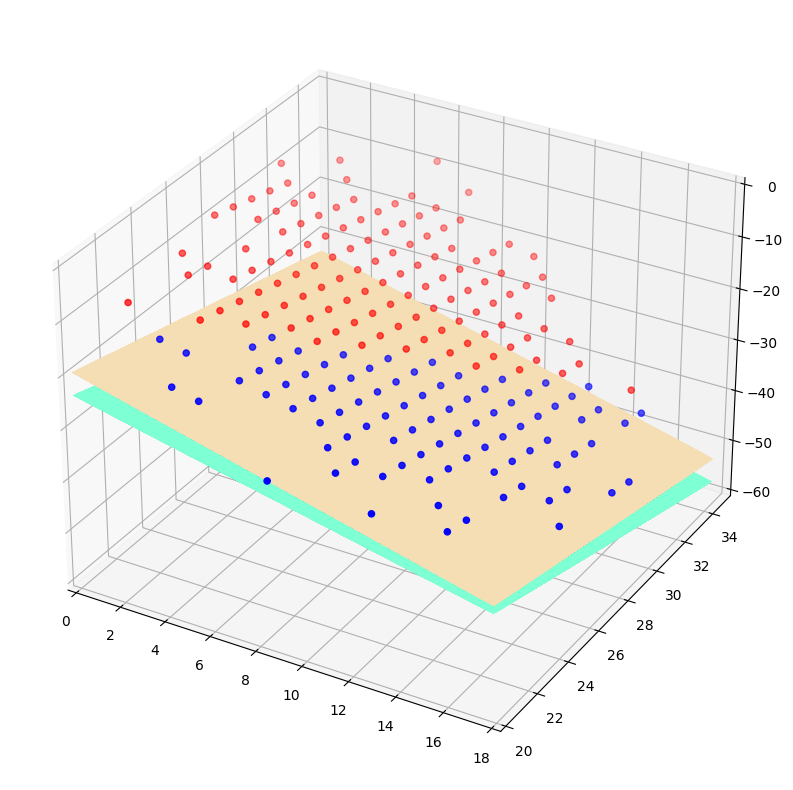

In [10]:
cc = ["r" if i[3] == 1 else "b" for i in np.array(data_6)]

x1 = np.linspace(0,18,100)
np.random.shuffle(x1)
x2 = np.linspace(20,35,100)
np.random.shuffle(x2)
X1,X2 = np.meshgrid(x1,x2)

X3 = ( np.log(pi[1]) + X1*np.log(p1[0]) + X2*np.log(p1[1])) / (-np.log(p1[2]))
X4 = ( np.log(pi[0]) + X1*np.log(p0[0]) + X2*np.log(p0[1])) / (-np.log(p0[2]))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X1,X2,X3,color = "wheat",shade=False)
ax.scatter3D(data_6[0],data_6[1],data_6[2],c=cc)
ax.plot_surface(X1,X2,X4,color = "aquamarine",shade=False)
ax.set_xlim([0,18])
ax.set_ylim([20,35])
ax.set_zlim([-60,0])
plt.show()

## 5. Apply Naive Bayes on Ionosphere data set.
#### (a) Apply k fold and hold out cross validation techniques.
#### (b) Report the preprocessing techniques if any.
#### (c) Report the value of the performance measures used

In [11]:
ion_data = pd.read_csv("ionosphere/ionosphere.data", header=None)
ion_data = pd.read_csv("ionosphere/ionosphere.data", header=None)
ion_data = ion_data.drop(columns=ion_data.columns[(ion_data==0).all()])
ion_data = ion_data.drop(columns=[0])
ion_data[34] = ion_data[34].replace('g',1)
ion_data[34] = ion_data[34].replace('b',0)
ion_data

,2,3,4,5,6,7,8,9,10,11,...,25,26,27,28,29,30,31,32,33,34
0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,0.13130,...,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,0.03281,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,0.01766,...,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,-0.03315,...,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [12]:
# class for performing gaussian naive bayes classification on continious dataset
class gaussian_naive_bayes():
    def __init__(self):
        self.mean = None
        self.std = None
        self.prior = None
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.std = np.zeros((len(self.classes), X.shape[1]))
        self.prior = np.zeros(len(self.classes))

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[i, :] = X_c.mean(axis=0)
            self.std[i, :] = X_c.std(axis=0)
            self.prior[i] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for i, c in enumerate(self.classes):
            prior = np.log(self.prior[i])
            class_conditional = np.sum(np.log(self._pdf(i, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        std = self.std[class_idx]
        numerator = np.exp(-(x - mean) ** 2 / (2 * std ** 2))
        denominator = np.sqrt(2 * np.pi * std ** 2)
        return numerator / denominator

In [13]:
gauss_nb = gaussian_naive_bayes()
x_train, x_test, y_train, y_test = train_test_split(ion_data.iloc[:,:-1], ion_data.iloc[:,-1], test_size=0.2, random_state=42)
gauss_nb.fit(x_train.to_numpy(), y_train.to_numpy())
predictions = gauss_nb.predict(x_test.to_numpy())
y_pred = predictions


#calculate confusion matrix
accuracy, precision, recall, f1_score = calculate_confusion_matrix(y_test.to_numpy(), y_pred)
print(f"accuracy of the model is : {accuracy}")
print(f"precision of the model is : {precision}")
print(f"recall of the model is : {recall}")
print(f"f1_score of the model is : {f1_score}")


accuracy of the model is : 0.8947368421052632
precision of the model is : 0.7906976744186046
recall of the model is : 0.8395061728395061
f1_score of the model is : 0.8169014084507042
